In [3]:
import music21
import torch
import plotly.graph_objects as go
import json
import numpy as np
from utils import getTopKAsMultiHot, tensor2midi, load_model, score_to_model_inputs #, plot_interleaved
from VAEModels import GaussianVAE
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
import webdataset as wds 
import quaternion as quat
import json
from matplotlib import cm
import torch.nn.functional as F


np.random.seed(1)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
# 13k 430


Using mps device


In [34]:
dat = sample_targets
print(sample_targets.shape)
mask = torch.tensor([0,0,1,0])
print(mask.ne(0).to(torch.float))
mask = torch.unsqueeze(mask, dim=-1)
mask = torch.unsqueeze(mask, dim=-1)
print(mask.shape)
print(dat.shape)
print(torch.masked_fill(dat, mask, 0))

torch.Size([92, 139])
tensor([0., 0., 1., 0.])
torch.Size([4, 1, 1])
torch.Size([92, 139])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],


In [149]:
#!pip3 install scipy
from scipy.interpolate import interp1d, interp2d, interpn


In [2]:
def rotate_3d_tensor(to_rotate, axis, theta):
    rotated = torch.tensor([],dtype=torch.float32)
    tempnew_new_coords = torch.tensor(3, dtype=torch.float32)
    rot_axis = np.array([0.] + axis)
    axis_angle = (theta*0.5) * rot_axis/np.linalg.norm(rot_axis)
    for triple in to_rotate.detach().cpu().numpy():
        v = np.array([0.] + triple)
        vec = quat.quaternion(*v)
        qlog = quat.quaternion(*axis_angle)
        q = np.exp(qlog)
        v_prime = q * vec * np.conjugate(q)
        tempcoords =  torch.tensor(v_prime.imag)
        rotated = torch.cat([rotated, torch.unsqueeze(tempcoords, dim=0)], dim=0)
    return rotated

def interpolate_3d_tensor(to_interpolate, steps):
    interpolated = torch.tensor([],dtype=torch.float32).to('mps')
    for idx in range(len(to_interpolate)-1):
        interpolated = torch.cat([interpolated, torch.unsqueeze(to_interpolate[idx], dim=0)], dim=0)
        step_dist = (to_interpolate[idx+1] - to_interpolate[idx])/(steps+1)
        for step in range(1, steps):
            interpolated = torch.cat([interpolated, torch.unsqueeze(to_interpolate[idx]+step_dist*step, dim=0)], dim=0)
    return interpolated


In [4]:
axis_angle

array([0.        , 0.41778637, 0.41778637, 0.10444659])

In [ ]:
plot_3d_t

In [3]:
def plot_reconstructed_gaussian(model, dim, r0=(-1, 1), n=25):
    model = model.to(device)
    norm = torch.distributions.Normal(0, 1)
    columns = torch.tensor([]).to(device)
    coords = torch.zeros([n, 3]).to(device)
    coords[:, dim] = norm.sample([n]).to(device) # ).values #np.linspace(*r0, n
    #for i, y in enumerate(np.linspace(*r0, n)):
    #    coords[i,dim] = y
    outs = model.decoder(coords)

    x_hat = getTopKAsMultiHot(outs.cpu(), 4).cpu().unique(dim=0, sorted=False)# + outs
    print(x_hat.shape)

    columns = torch.squeeze(x_hat) # torch.cat([columns, torch.unsqueeze(x_hat, dim=0)], dim=0)
    #plt.imshow(columns, extent=[*r0, *r1])
    #columns = torch.squeeze(columns)
    fig = plt.figure(figsize=(12, 6), layout="constrained")
    embedding_ax, recons_ax = fig.add_subplot(1, 2, projection="3d")
    embedding_ax.scatter()
    recons_ax.imshow(columns.T.cpu().detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
    return columns[:, 0:128]

In [39]:
def plot_reconstructed_lin(model, r0=(-4, 4), r1=(-4, 4), r2=(-4, 4), n=5):
    w = 28
    img = np.zeros((n*w, n*w))
    count = 0
    zs = torch.tensor([])
    for i, y in enumerate(np.linspace(*r2, n)):
        for j, x in enumerate(np.linspace(*r1, n)):
            for k, z in enumerate(np.linspace(*r0, n)):
                z = torch.Tensor([x, y, z])
                zs = torch.cat([zs, torch.unsqueeze(z, dim=0)], dim=0)
                count += 1
                         
    print(count)
    outs = model.decoder(zs.to('mps'))
    plotzs = zs.cpu().detach().numpy()
    x_hat = getTopKAsMultiHot(outs.cpu(), 4).cpu().unique(dim=0, sorted=False)# + outs
    columns = torch.squeeze(x_hat)
    #fig = plt.figure(figsize=(12, 6), layout="constrained")
    print(zs.shape)
    kwrs = {'projection': "3d"}
    fig, embedding_ax = plt.subplots(1, 1, figsize=(24, 12), subplot_kw=kwrs)
    #embedding_ax = fig.add_subplot(projection="3d")
    #recons_ax = plt.subplot(111)
    embedding_ax.plot3D(plotzs[:, 0], plotzs[:, 1], plotzs[:, 2])
    #recons_ax.imshow(columns.T.cpu().detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
    plt.show()
    return columns[:, 0:128]
    #plt.imshow(columns.T.cpu().detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')



In [40]:
cols = plot_reconstructed_lin(model)


125
torch.Size([125, 3200])
torch.Size([125, 25, 128])


RuntimeError: Length of output_size does not match NestedTensor dims. Broadcasting is not supported.

In [4]:
import math
from scipy.interpolate import CubicSpline
import json
from torch.profiler import profile, record_function, ProfilerActivity
DURATION_WIDTH = 12
with open('./duration_map.json', 'r') as f:
    duration_map = json.load(f)
print('hello')

run_id = 'f65f4cbc-ffc5-11ed-ae5e-a283b53598de'
model = load_model(run_id,8, device)
activation={}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


model.encoder.register_forward_hook(get_activation("encoder"))

sample_targets, dense_targets, sample_labels, sample_mask_inputs = score_to_model_inputs("~/local_corpus/bach/chorales_006005b_(c)greentree.mid")
sample_mask_inputs = sample_mask_inputs.repeat(3, 1)
sample_masks = torch.unsqueeze(sample_mask_inputs, dim=-1).to(torch.float)
sample_targets = F.one_hot(dense_targets, 129)[:, :, 1:].to(torch.float)
sample_targets = sample_targets.repeat(3, 1, 1)
sample_masks = sample_masks.expand(sample_targets.shape)


sample_color_strings = [
    json.dumps(list(n), separators=(",", ":")) for n in sample_labels
]
print(sample_color_strings)


bach = music21.converter.parse('~/local_corpus/bach/chorales_006005b_(c)greentree.mid')

durations = []
print('hello')

model.eval()
sample_normals = []
for chord in bach.chordify().recurse().getElementsByClass(['Chord', 'Measure']):
    if 'Chord' in chord.classes:
        durations.extend([chord.duration] * 3)



sampledcoords = torch.tensor([], device='mps')
with torch.no_grad():
    
    #sample_outputs = model(sample_targets.to('mps'), masks=sample_masks, maskinputs=sample_mask_inputs)
    #coords = activation["encoder"]
    with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
        coords = model.encoder(sample_targets.to('mps'), masks=sample_masks, maskinputs=sample_mask_inputs)
    
    print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))
    print(coords.shape)
    #coords = torch.cat([sampledcoords, torch.unsqueeze(tempcoords, dim=0)], dim=0)
    #coords = torch.mean(sampledcoords, dim=0)
    #print(coords.shape)
    #print(torch.rot90(coords, 1, [0, 1]).T.shape)
    #print(torch.rot90(coords, 1, [0, 1]).T)
    #new_coords = torch.rot90(coords, 1, [1,0]).T # torch.tensor([], device='mps')
    import matplotlib.path as mpath
    import matplotlib.patches as mpatches
    #new_coords = torch.rot90(coords, 1, [1,0]).T
    #new_coords = coords + 0.5
    #new_coords = rotate_3d_tensor(coords, [1,1,1], np.pi/6).to(torch.float32)
    #new_coords = coords*2
    new_coords = interpolate_3d_tensor(coords, 3)
    kwrs = {'projection': "3d"}

    #fun = interpn(x=new_coords[:, 0], y=new_coords[:, 1].detach().cpu().numpy())
    #interp = RegularGridInterpolator((x, y), data, method='nearest')


    fig, (embedding_ax, rotated_ax) = plt.subplots(1, 2, figsize=(24, 12), subplot_kw=kwrs)
    print('hello')
    embedding_ax.scatter3D(coords[:, 0].detach().cpu().numpy(), 
                        coords[:, 1].detach().cpu().numpy(),
                        coords[:, 2].detach().cpu().numpy())
    embedding_ax.plot(coords[0:8, 0].detach().cpu().numpy(), 
                      coords[0:8, 1].detach().cpu().numpy(),
                      coords[0:8, 2].detach().cpu().numpy())
    embedding_ax.scatter3D(coords[0, 0].detach().cpu().numpy(), 
                        coords[0, 1].detach().cpu().numpy(),
                        coords[0, 2].detach().cpu().numpy(), s=80)

    rotated_ax.scatter3D(new_coords[:, 0].detach().cpu().numpy(), 
                        new_coords[:, 1].detach().cpu().numpy(),
                        new_coords[:, 2].detach().cpu().numpy())
    rotated_ax.plot(new_coords[0:8, 0].detach().cpu().numpy(), 
                      new_coords[0:8, 1].detach().cpu().numpy(),
                      new_coords[0:8, 2].detach().cpu().numpy())
    rotated_ax.scatter3D(new_coords[0, 0].detach().cpu().numpy(), 
                        new_coords[0, 1].detach().cpu().numpy(),
                        new_coords[0, 2].detach().cpu().numpy(), s=80)
    
    #embedding_ax.bar(list(range(0, (len(x)*4), 4)), coords[:, 0].detach().cpu().numpy())
    #embedding_ax.bar(list(range(1, (len(x)*4), 4)), coords[:, 1].detach().cpu().numpy())
    #embedding_ax.bar(list(range(2, (len(x)*4), 4)), coords[:, 2].detach().cpu().numpy())
    #embedding_ax.bar(list(range(3, (len(x)*4), 4)), np.zeros_like(coords[:, 2].detach().cpu().numpy()))
    #embedding_ax.barh(list(range(2, (len(x)*3)-3, 3)), coords[:, 2].detach().cpu().numpy())

    #coords[:, 1].detach().cpu().numpy()
    #csp = cs(x)
    #embedding_ax.bar(csp[:, 0],csp[:, 1],csp[:, 2])
    #new_coords = coords+0.3
    #new_coords = torch.rot90(new_coords, 1, [1,0]).T 
    plt.show()
    '''for ind in range(len(coords)-1):
        cur = coords[ind]
        next = coords[ind+1]
        steps = (next - cur) / 5.0
        #print(steps)
        lastone = cur.detach()
        for newind in range(5):
            #print(f"cur is {cur}")
            #print(f"last one is {lastone}")
            newone = lastone + steps
            #print(f"new one is {newone}")
            new_coords = torch.cat([new_coords, torch.unsqueeze(newone, 0)], 0)
            lastone = newone.detach()'''
    #print(new_coords.shape)

    sample_outputs = model.decoder(coords.to('mps'),masks=sample_masks, maskinputs=sample_mask_inputs)
    sample_outputs_orig = model.decoder(new_coords.to('mps'),masks=sample_masks, maskinputs=sample_mask_inputs)
    
    print(sample_outputs.shape)
    #sample_outputs = torch.mean(outputList, dim=0)
    recons_midis = torch.argmax(sample_outputs, dim=-1).cpu().tolist()
    recons_midis_orig = torch.argmax(sample_outputs_orig, dim=-1).cpu().tolist()
   
    #x_hat_durs = getTopKAsMultiHot(sample_outputs[:, 139:150], 1)
    #print(x_hat)
    #fig, axs = plt.subplots(3, 1)
    cs = recons_midis # torch.cat([columns, torch.unsqueeze(x_hat, dim=0)], dim=0)
    rs = recons_midis_orig
#axs[0].imshow(sample_outputs[:, 0:128].T.detach().cpu().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
#axs[1].imshow(x_hat.T.detach().cpu().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
#axs[2].imshow(sample_targets[:, 0:128].T.detach().cpu().numpy(), cmap='gray', aspect='auto', interpolation='nearest')

#plt.imshow(columns, extent=[*r0, *r1])
#columns = torch.squeeze(columns)
plt.show() #.imshow(sample_outputs.T.detach().numpy(), cmap='gray', aspect='auto', interpolation='nearest')
#ts_durs = torch.argmax(sample_targets[:, 139:150], dim=-1).tolist()
#print(len(ts_durs))

#cs_durs = torch.argmax(x_hat_durs, dim=-1).tolist()
#print(len(cs_durs))
#print(ts, cs)
print(cs)
play_midi_chords(cs, durations, 'original_new_model4.midi')
play_midi_chords(rs, durations, 'rot_new_model4.midi')
#for i in range(len(sample_targets)//8):
#    play_midi_chord(ts[i])
#for i in range(len(columns)//8):
#    play_midi_chord(cs[i])

hello


/Users/hansen/dev/chord_encoder/utils.py:50: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:179.)
  nested_midis = torch.nested.nested_tensor(
STAGE:2023-05-31 14:13:44 14637:416212 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


['[0,4,7]', '[0,3,8]', '[0,3,4,8]', '[0,3,8]', '[0,3,6,8]', '[0,4,7]', '[0,3,7]', '[0,4,5,9]', '[0,6,7,11]', '[0,3,8]', '[0,3,5,10]', '[0,4,7]', '[0,2,4,9]', '[0,1,3,7]', '[0,3,5]', '[0,4,7]', '[0,4,7]', '[0,4,7]', '[0,2,6,9]', '[0,3,6,9]', '[0,5,7]', '[0,4,10]', '[0,4,9]', '[0,4,10]', '[0,4,7]', '[0,4,7]', '[0,3,8]', '[0,2,6,9]', '[0,3,9]', '[0,4,7]', '[0,4,9]', '[0,4,10]', '[0,4,7]', '[0,2,7]', '[0,4,7]', '[0,3,5,10]', '[0,3,8]', '[0,2,8,10]', '[0,4,10]', '[0,4,7]', '[0,2,6,9]', '[0,6,9]', '[0,3,9]', '[0,3,7]', '[0,5,7]', '[0,5,7,10]', '[0,5,7,9]', '[0,4,10]', '[0,4,7]', '[0,4,7]', '[0,4,7]', '[0,3,5,10]', '[0,3,8]', '[0,3,5,10]', '[0,3,8]', '[0,4,7]', '[0,4,7]', '[0,2,5,10]', '[0,2,7]', '[0,3,8]', '[0,3,8]', '[0,1,6,10]', '[0,4,7]', '[0,4,7]', '[0,5,9]', '[0,4,9]', '[0,5,9,11]', '[0,2,9,11]', '[0,4,7]', '[0,2,6,9]', '[0,3,8]', '[0,4,10]', '[0,4,7,10]', '[0,4,6,9]', '[0,4,10]', '[0,3,6,10]', '[0,5,9]', '[0,2,5,9]', '[0,2,9,11]', '[0,4,7]', '[0,3,8]', '[0,4,7]', '[0,3,8]', '[0,3,6,8]'

STAGE:2023-05-31 14:13:44 14637:416212 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 14:13:44 14637:416212 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


RuntimeError: Profiler didn't finish running

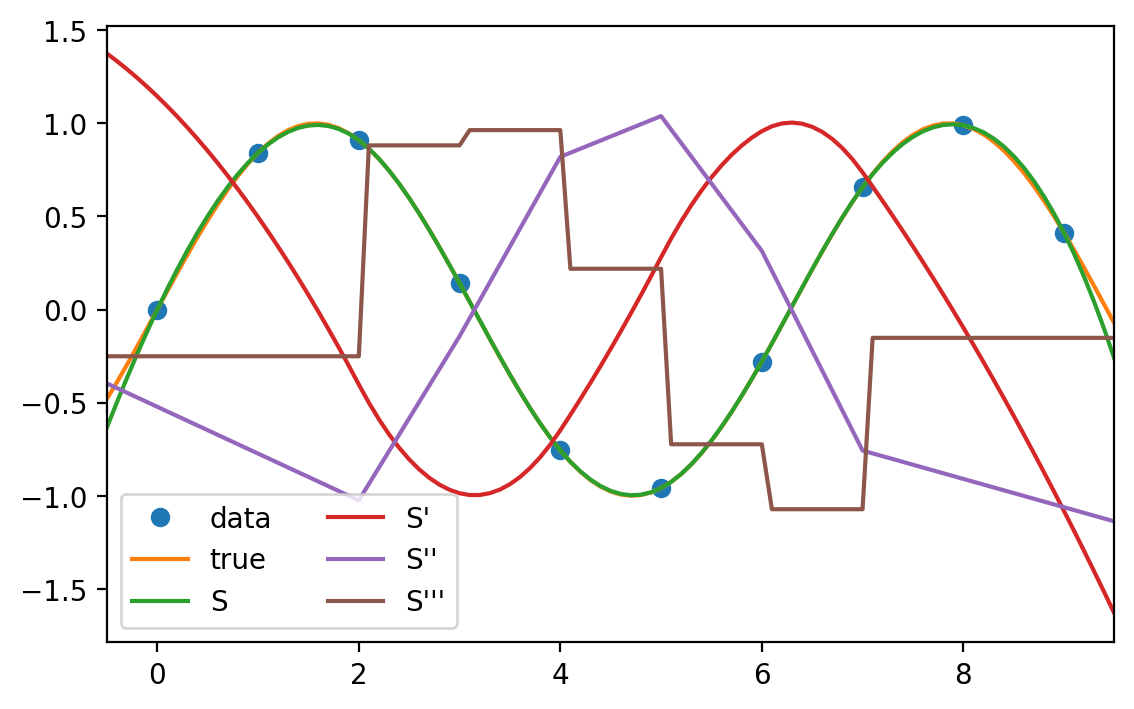

In [240]:
x= np.arange(10)
y = np.sin(x)
cs = CubicSpline(x, y)
xs = np.arange(-0.5, 9.6, 0.1)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, np.sin(xs), label='true')
ax.plot(xs, cs(xs), label="S")
ax.plot(xs, cs(xs, 1), label="S'")
ax.plot(xs, cs(xs, 2), label="S''")
ax.plot(xs, cs(xs, 3), label="S'''")
ax.set_xlim(-0.5, 9.5)
ax.legend(loc='lower left', ncol=2)
plt.show()

In [5]:
def play_midi_chord(chordList):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=100))
    #for chord in chordList:
    c = music21.chord.Chord([int(chord) for chord in chordList])
    s.append(c)
    sp = music21.midi.realtime.StreamPlayer(s)
    sp.play()

In [5]:
def play_midi_chords(chordList, durList, filename):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=100))
    part1 = music21.stream.Part()
    part2 = music21.stream.Part()
    part3 = music21.stream.Part()
    part4 = music21.stream.Part()
    def set_duration(note):
        note[0].duration = note[1]
        return note[0]
    for chord, dur in zip(chordList, durList):
        notes = [music21.note.Note(n) for n in chord]
        nwd = list(map(set_duration, [(n, dur) for n in notes] ))
        part1.append(nwd[0])
        part2.append(nwd[1])
        part3.append(nwd[2])
        part4.append(nwd[3])
        #c = music21.chord.Chord([int(n) for n in chord])
        #c.duration = dur
    s.append(part1)
    s.append(part2)        
    s.append(part3)
    s.append(part4)
    #sp = music21.midi.realtime.StreamPlayer(s)
    s.write('midi', fp=filename)
    #sp.play()

In [222]:
def load_plot_widget(embedding, labels, colors):
    # create our callback function
    def update_point(trace, points, selector):
        point_idx = points.point_inds[0]
        midi_nums =  json.loads(scatter.customdata[point_idx])
        play_midi_chord([int(num) for num in midi_nums])
    
    x = embedding[:, 0]
    y = embedding[:, 1]
    f = go.FigureWidget([go.Scatter(x=x, y=y, mode='markers', customdata=labels)])
    f.update_layout(width=750)
    f.update_layout(height=750)
    scatter = f.data[0]
    scatter.marker.color = colors
    scatter.marker.size = [5] * len(embedding)
    f.layout.hovermode = 'closest'
    scatter.on_click(update_point)
    return f

In [14]:

import uuid
import json

ORIGINAL_DIM = 128
LATENT_DIM = 3
MIN_MIDI = 35
MAX_MIDI = 90
DATA_LENGTH = MAX_MIDI - MIN_MIDI
INTERMEDIATE_DIMS = DATA_LENGTH*32
LEARNING_RATE = 1e-2
RHO  = 0.0074
BETA = 4
KLD_WEIGHT = 0. #
WEIGHT_MULT = 1.# 1e3
SPARSE_WEIGHT = 1
RUN_UUID = str(uuid.uuid1())
BATCH_SIZE=256
KL_SOFTMAX_DIM=1


'''config = {
    'original_dim': ORIGINAL_DIM,
    'intermediate_dim': 880,
    'latent_dim': LATENT_DIM,
    'data_length': DATA_LENGTH,
    'learning_rate': LEARNING_RATE,
    'kld_weight': KLD_WEIGHT,
    'bce_weight': WEIGHT_MULT,
    'sparsity_weight': SPARSE_WEIGHT,
    'batch_size': BATCH_SIZE,
    'class_weight_exponent': 0.125
}'''
#/Users/hansen/dev/chord_encoder/outputs/data/49c3dc9a-f1c7-11ed-926a-a283b53598de/model_state
# run_id = 'ce28d328-f983-11ed-ade8-a283b53598de' # 15 really good
# run_id = '7f086fe2-f9ab-11ed-bad3-a283b53598de'  # 15 pretty good
# run_id = 'ca4b656e-fb76-11ed-9c9d-a283b53598de' ## 65 best best best
#run_id = '42d9e0cc-fbd7-11ed-a240-a283b53598de'
#run_id = '73d23c42-ff6a-11ed-93be-a283b53598de' # first masked
run_id = '42ca8230-ffab-11ed-8d47-a283b53598de'
model = load_model(run_id, 2, device)
activation={}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


model.encoder.register_forward_hook(get_activation("encoder"))
'''with open(f"./outputs/data/{run_id}/config.json") as f:
    config = json.load(f)
model = GaussianVAE(**config).to(device)
#model_path = f"./outputs/sparse_ae3300.pth"

model_path = f"./outputs/data/{run_id}/model_state/80.pth"
model.load_state_dict(torch.load(model_path))
model.eval()'''

#labels = [json.dumps([int(i) for i in ints if int(i) != 0], separators=(',', ':')) for ints in testset.uniques.tolist()]
#colors = torch.mean(testset.uniques.to(torch.float),1)
#img = testset[:]    
#print(img.shape)#
#img = img.view(img.size(0), -1)
#print(img.shape)
#img.to(device)
#model.eval()
#with torch.no_grad():
#    reconstructions = model(img)
#    embeddings = model.encoder(img)

#print(torch.topk(reconstructions, 4))
#load_plot_widget(embeddings, labels, colors)
#plot_embedding_space(embeddings, colors)
#plot_interleaved(reconstructions, img,embeddings, colors, 4900, 42.5791282654)

'with open(f"./outputs/data/{run_id}/config.json") as f:\n    config = json.load(f)\nmodel = GaussianVAE(**config).to(device)\n#model_path = f"./outputs/sparse_ae3300.pth"\n\nmodel_path = f"./outputs/data/{run_id}/model_state/80.pth"\nmodel.load_state_dict(torch.load(model_path))\nmodel.eval()'

In [5]:
cols = plot_reconstructed(model, 2, 0,r0=(-10, 10), n=30)
print(cols.shape)
cols = cols

TypeError: plot_reconstructed() got multiple values for argument 'r0'

In [ ]:
midis = torch.topk(reconstructions, 4).indices + MIN_MIDI
num_chords = len(midis)
src =torch.ones([num_chords, 128])
zeros = torch.zeros([num_chords, 128], dtype=src.dtype)
zeros.scatter_(1, midis, src)[:, MIN_MIDI:MAX_MIDI].shape


In [ ]:
import webdataset as wds

In [ ]:
wds.Shard

In [ ]:
testset = (
        wds.WebDataset("./shards/chordnet-train-{000000..000003}.tgz")
        .decode()
        .to_tuple("pth json")
    )

In [ ]:
import io
i = 0
for sample, meta in testset:
    print(sample.shape)
    print(len(meta))
    i += 1
    print(f"{i} chunks so far")

In [ ]:
l = [1,3,2,4,5]
sl = set(l)
print(tuple(sl))

In [9]:
import plotly.graph_objects as go
#coords = coords.detach().cpu().numpy()
theframes= [go.Frame(data=[go.Scatter3d(mode="lines+markers",x=coords[1:n, 0], y=coords[1:n, 1],z=coords[1:n,2],marker=dict(color='blue', size=3))]) for n in range(1,len(coords))] 
fig = go.Figure(
    data=[go.Scatter3d(x=coords[0:1, 0], y=coords[0:1, 1], z=coords[0:1,2],marker=dict(color='red'))],
    layout=go.Layout(
        xaxis=dict(range=[-5, 5], autorange=True),
        yaxis=dict(range=[-5, 5], autorange=True),
        
        title="BWV 60",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
    ),
    frames=theframes
)

fig.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Fixing random state for reproducibility
np.random.seed(19680801)


def Gen_RandLine(length, dims=2):
    """
    Create a line using a random walk algorithm

    length is the number of points for the line.
    dims is the number of dimensions the line has.
    """
    lineData = np.empty((dims, length))
    lineData[:, 0] = np.random.rand(dims)
    for index in range(1, length):
        # scaling the random numbers by 0.1 so
        # movement is small compared to position.
        # subtraction by 0.5 is to change the range to [-0.5, 0.5]
        # to allow a line to move backwards.
        step = ((np.random.rand(dims) - 0.5) * 0.1)
        lineData[:, index] = lineData[:, index - 1] + step

    return lineData


def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Fifty lines of random 3-D lines
data = [Gen_RandLine(25, 3) for index in range(50)]

# Creating fifty line objects.
# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

# Setting the axes properties
ax.set_xlim3d([0.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([0.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_lines, 25, fargs=(data, lines),
                                   interval=50, blit=False)
video = line_ani.to_html5_video()

html = display.HTML(video)

display.display(html)


<IPython.core.display.Javascript object>